## Notebook to explore some samples of NEON hyperspectral image data

Written by Chris Stewart - 2021/02/10


The purpose of this notebook is to ...

TODO: 
- clean up data import code
- improve this markdown text box explaining the purpose of this notebook
- 


NEON Citation:
National Ecological Observatory Network. 2021. Data Product DP3.30006.001, Spectrometer orthorectified surface directional reflectance - mosaic. Provisional data downloaded from http://data.neonscience.org on February 11, 2021. Battelle, Boulder, CO, USA NEON. 2021.

In [33]:
# libraries
# data
import pandas as pd
# import geopandas as geopd # for working with geolocation data
import numpy as np
import hyperspy.api as hs
import h5py

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import cartopy.crs as ccrs # for working with geolocation data
# import cartopy.feature as cfeature

# ml
import sklearn as skl

# utilites
import sys
import os 
from pathlib import Path
import datetime as dt
from tqdm.notebook import tqdm, trange # progress bars
tqdm.pandas()

# dataframe options
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## TO DO:

### Data loading code:
code that takes in a filepath and walks the folders and files and returns filenames and paths of all h5 files

function that takes in the filename and path of a hdf5 (.h) file and reads the hdf5 structure and available datasets, prints group names, dataset names and attributes

function that takes in a filename and path loads in the reflectance data and a dictionary of the metadata

### EDA:

after loading data perform some sanity check: check dimensions of arrays and size in memory, min/maxes of values, plot histograms of distrobutions of values for reflectance and wavelength. Check FWHM distances and see if they are consistant and check band centres and see if they are consistant (i.e. evenly distributed accross spectrum)

plot sprectral graph, for single and multiple spectra

optional: tool that shows image and lets you click on pixel and shows you the spectral graph on that pixel or range of pixels

### Spatial resampling:
write function that takes in array of data and downscales based on desired GSD scale parameter
"slice method"

### Visualize the image:
need function/code that can translate between spectral and reflectance data and RGB or other values for easy plotting/visualization with PIL


### NDVI:
function that calculates NDVI and translates that to RGB values for visualization
plot of NDVI 







## Data loading functions:

1. find_files - code that takes in a filepath and walks the folders and files and returns filenames and paths of all h5 files
2. hdf5 file dump - useful exploratory code to map the structure of NEON's hdf5 files and metadata
3. 

In [42]:
def find_files(data_dir_path):
    """
    This function takes in a path to a data directory, walks the directory and 
    returns a dictionary of the filenames and paths of all the data files.
    """
    
    # get all the h5 data filenames and paths
    file_dict = {} # to store file:path pairs
    print('Finding data files...')
    for p, _, file in os.walk(data_path): # get all the data files and their paths
        for f in file:
            if f.endswith(".h5"): # only .h5 files read in
                file_dict[f] = os.path.join(p, f) # if you want a string path
                #file_dict[f] = Path(os.path.join(p, f)) # if you want a Path object path

    return file_dict

### Test out the find_files function:

In [43]:
data_dir_path = Path(os.getcwd()).parents[0] / 'data' / 'NEON' # get path to data files

file_dict = find_files(data_dir_path)
file_dict

Finding data files...


{'NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5074000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\

In [57]:
# # my manual lame way
# with h5py.File("NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5",'r') as f:
#     groupNames_0 = [n for n in f.keys()]
#     print(groupNames_0)
#     groupNames_1 = [n for n in f['ABBY'].keys()]
#     print(groupNames_1)
#     groupNames_2 = [n for n in f['ABBY/Reflectance'].keys()]
#     print(groupNames_2)
#     #datasetNames = [n for n in groupNames_1.keys()]
#     #dset = groupNames_1['Reflectance']
#     #dset

['ABBY']
['Reflectance']
['Metadata', 'Reflectance_Data']


In [58]:
# HDF5 file structure map from this SO answer: https://stackoverflow.com/a/53340677
# Much more better!
def descend_obj(obj,sep='\t'):
    """
    Iterate through groups in a HDF5 file and prints the groups and datasets names and datasets attributes
    """
    if type(obj) in [h5py._hl.group.Group,h5py._hl.files.File]:
        for key in obj.keys():
            print(sep,'-',key,':',obj[key])
            descend_obj(obj[key],sep=sep+'\t')
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            print(sep+'\t','-',key,':',obj.attrs[key])

def h5dump(path,group='/'):
    """
    print HDF5 file metadata

    group: you can give a specific group, defaults to the root group
    """
    with h5py.File(path,'r') as f:
         descend_obj(f[group])

### Test out the h5dump function:

This will give us the structure of the NEON hdf5 file and its available datasets within - of particular interest to us here are three datasets:
- Wavelength
- Full Width Half Maximum (FWHM)
- Reflectance

In [59]:
h5dump("NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5")

	 - ABBY : <HDF5 group "/ABBY" (1 members)>
		 - Reflectance : <HDF5 group "/ABBY/Reflectance" (2 members)>
			 - Metadata : <HDF5 group "/ABBY/Reflectance/Metadata" (7 members)>
				 - Ancillary_Imagery : <HDF5 group "/ABBY/Reflectance/Metadata/Ancillary_Imagery" (14 members)>
					 - Aerosol_Optical_Depth : <HDF5 dataset "Aerosol_Optical_Depth": shape (1000, 1000), type "<i2">
							 - Band_Names : b'AOT (aerosol optical thickness at 550 nm)*1000'
							 - Data_Ignore_Value : -9999.0
							 - Description : b'Aerosol Optical Depth at 500 nm.'
							 - Scale_Factor : 1000.0
							 - Units : b'Aerosol Optical Depth at 500 nm.'
					 - Aspect : <HDF5 dataset "Aspect": shape (1000, 1000), type "<f4">
							 - Data_Ignore_Value : -9999.0
							 - Description : b'Aspect used as input to ATCOR'
							 - Dimension_Labels : b'-'
							 - Scale_Factor : 1.0
							 - Units : b'degrees'
					 - Cast_Shadow : <HDF5 dataset "Cast_Shadow": shape (1000, 1000), type "|u1">
							 - Data_Ign

In [7]:
wavelength_dset = f['/ABBY/Reflectance/Metadata/Spectral_Data/Wavelength'] # wavelength dataset
FWHM_dset = f['/ABBY/Reflectance/Metadata/Spectral_Data/FWHM'] # FWHM dataset
reflectance_dset = f['/ABBY/Reflectance/Reflectance_Data'] # reflectance dataset

### Some functions based on example code from NEON NDVI code examples


https://www.neonscience.org/resources/learning-hub/tutorials/calc-ndvi-tiles-py


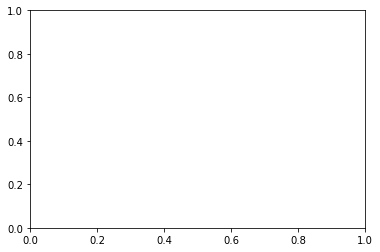

In [35]:
# %load ../neon_aop_hyperspectral.py
"""
Created on Wed Jun 20 10:34:49 2018

@author: bhass
"""

#import matplotlib.pyplot as plt
#import numpy as np
#import h5py, os, copy

def aop_h5refl2array(refl_filename):
    """aop_h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
           1. reflectance array (with the no data value and reflectance scale factor applied)
           2. dictionary of metadata including spatial information, and wavelengths of the bands
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            bad_band_window1 (tuple)
            bad_band_window2 (tuple)
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
    --------
    NOTE: This function applies to the NEON hdf5 format implemented in 2016, and should be used for
    data acquired 2016 and after. Data in earlier NEON hdf5 format (collected prior to 2016) is 
    expected to be re-processed after the 2018 flight season. 
    --------
    Example Execution:
    --------
    sercRefl, sercRefl_metadata = h5refl2array('NEON_D02_SERC_DP3_368000_4306000_reflectance.h5') """

    

    #Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]

    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflData = refl['Reflectance_Data']
    reflRaw = refl['Reflectance_Data'].value

    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
    metadata['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

    #Extract no data value & scale factor
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    #metadata['interleave'] = reflData.attrs['Interleave']

    #Apply no data value
    reflClean = reflRaw.astype(float)
    arr_size = reflClean.shape
    if metadata['data ignore value'] in reflRaw:
        print('% No Data: ',np.round(np.count_nonzero(reflClean==metadata['data ignore value'])*100/(arr_size[0]*arr_size[1]*arr_size[2]),1))
        nodata_ind = np.where(reflClean==metadata['data ignore value'])
        reflClean[nodata_ind]=np.nan 

    #Apply scale factor
    reflArray = reflClean/metadata['reflectance scale factor']

    #Extract spatial extent from attributes
    metadata['spatial extent'] = reflData.attrs['Spatial_Extent_meters']

    #Extract bad band windows
    metadata['bad band window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad band window2'] = (refl.attrs['Band_Window_2_Nanometers'])

    #Extract projection information
    #metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)

    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value

    hdf5_file.close        

    return reflArray, metadata

def plot_aop_refl(band_array,refl_extent,colorlimit=(0,1),ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='Greys'):

    '''plot_refl_data reads in and plots a single band or 3 stacked bands of a reflectance array
    --------
    Parameters
    --------
        band_array: array of reflectance values, created from aop_h5refl2array
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) 
                     use metadata['spatial extent'] from aop_h5refl2array function
        colorlimit: optional, range of values to plot (min,max). 
                    - helpful to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: optional; plot title (string)
        cmap_title: optional; colorbar title 
        colormap: optional (string, see https://matplotlib.org/examples/color/colormaps_reference.html) for list of colormaps
    --------
    Returns 
    --------
        plots flightline array of single band of reflectance data
    --------

    Examples:
    --------
    plot_aop_refl(sercb56,
              sercMetadata['spatial extent'],
              colorlimit=(0,0.3),
              title='SERC Band 56 Reflectance',
              cmap_title='Reflectance',
              colormap='Greys_r') '''

    import matplotlib.pyplot as plt

    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation for ticklabels
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

def stack_rgb(reflArray,bands):

    red = reflArray[:,:,bands[0]-1]
    green = reflArray[:,:,bands[1]-1]
    blue = reflArray[:,:,bands[2]-1]

    stackedRGB = np.stack((red,green,blue),axis=2)

    return stackedRGB

def plot_aop_rgb(rgbArray,ext,ls_pct=5,plot_title=''):

    from skimage import exposure

    pLow, pHigh = np.percentile(rgbArray[~np.isnan(rgbArray)], (ls_pct,100-ls_pct))
    img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
    plt.imshow(img_rescale,extent=ext)
    plt.title(plot_title + '\n Linear ' + str(ls_pct) + '% Contrast Stretch'); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

## EDA:

In [15]:
print(reflectance_dset.dtype)
print(reflectance_dset.shape)

int16
(1000, 1000, 426)


In [17]:
print(wavelength_dset.dtype)
print(wavelength_dset.shape)

float32
(426,)


In [60]:
print(FWHM_dset.dtype)
print(FWHM_dset.shape)

float32
(426,)


In [16]:
x_len = reflectance_dset.shape[0]
range(x_len)

range(0, 1000)

In [ ]:
reflectance_dset[0,0,:]

In [10]:
wavelength_dset.nbytes # size of array in memory

1704

In [11]:
wavelength_dset[:]

array([ 381.598 ,  386.6077,  391.6175,  396.6273,  401.637 ,  406.6468,
        411.6566,  416.6663,  421.6761,  426.6858,  431.6956,  436.7054,
        441.7151,  446.7249,  451.7347,  456.7444,  461.7542,  466.764 ,
        471.7737,  476.7835,  481.7933,  486.803 ,  491.8128,  496.8226,
        501.8323,  506.8421,  511.8519,  516.8616,  521.8714,  526.8812,
        531.8909,  536.9007,  541.9105,  546.9202,  551.93  ,  556.9398,
        561.9495,  566.9593,  571.9691,  576.9788,  581.9886,  586.9984,
        592.0081,  597.0179,  602.0277,  607.0374,  612.0472,  617.057 ,
        622.0667,  627.0765,  632.0863,  637.096 ,  642.1058,  647.1156,
        652.1253,  657.1351,  662.1449,  667.1546,  672.1644,  677.1742,
        682.1839,  687.1937,  692.2035,  697.2132,  702.223 ,  707.2328,
        712.2425,  717.2523,  722.2621,  727.2718,  732.2816,  737.2914,
        742.3011,  747.3109,  752.3207,  757.3304,  762.3402,  767.35  ,
        772.3597,  777.3695,  782.3793,  787.389 , 

<AxesSubplot:>

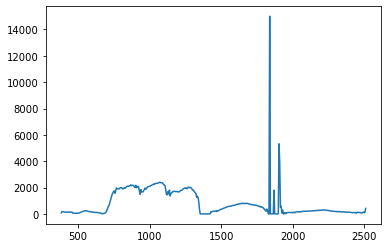

In [18]:
# plot one random spectral line
sns.lineplot(x=wavelength_dset[:], y=reflectance_dset[10,10,:])

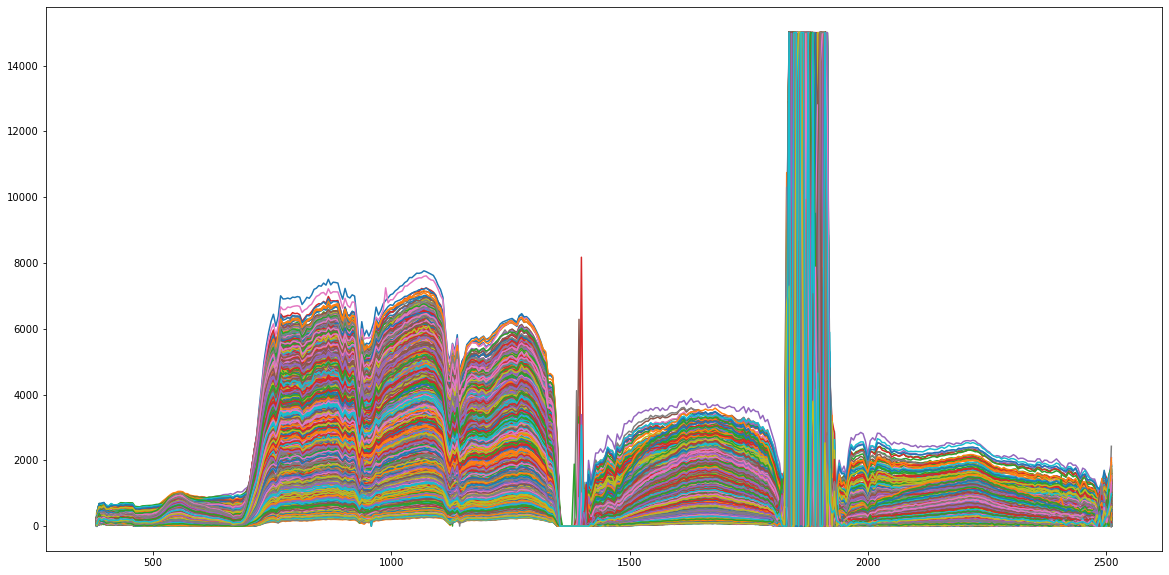

In [19]:

fig, ax = plt.subplots(figsize=(20,10))
#fig, ax = plt.subplots(nrows=7, ncols=3, figsize=(20, 38))

# array dimension lengths
x_len = reflectance_dset[0:5].shape[0]
y_len = reflectance_dset[0:5].shape[1]
z_len = reflectance_dset.shape[2]

cmap = sns.color_palette("Spectral", as_cmap=True)

for x in range(x_len):
    for y in range(y_len):
            sns.lineplot(x=wavelength_dset[:], y=reflectance_dset[x,y,:], ax=ax)

plt.show()

In [ ]:
# try and load image into HyperSpy
img = hs.load('NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5', reader="h5")      #file_dict[file_names_ls[0]])
img        

In [24]:
# GET THE ACTUAL IMAGE WORKING

In [34]:
from colorsys import hsv_to_rgb
from PIL import Image

# Make some RGB values. 
# Cycle through hue vertically & saturation horizontally
colors = []
for hue in range(360):
    for sat in range(100):
        # Convert color from HSV to RGB
        rgb = hsv_to_rgb(hue/360, sat/100, 1)
        rgb = [int(0.5 + 255*u) for u in rgb]
        colors.extend(rgb)

# Convert list to bytes
colors = bytes(colors)
img = Image.frombytes('RGB', (100, 360), colors)
img.show()
#img.save('hues.png')

In [31]:
from PIL import Image
im = Image.open("NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5")

## WIP CODE BELOW CLEAN/DELETE LATER -----------------------------------

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, -z, zdir='z', c= 'red')
# plt.savefig("demo.png")